In [1]:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

from matplotlib import pyplot as plt

import copy
import tqdm  # Pretty progress bars
import joblib  # Writing and loading

import sys
sys.path.insert(0, '../')
import vqe
import ising_chain
import annni_model
import hamiltonians
import visualization as qplt
import losses
##############

from jax.example_libraries import optimizers

In [2]:
# System parameters
N = 8
J = 1

# Learning parameters
lr = .3


In [3]:
Hs = hamiltonians.hamiltonian(ising_chain.build_Hs, N = N, J = J, n_states = 100, ring = False)

In [4]:
def compute_excited_states(Hs, kth):
    energies = []
    
    energies_0, energies_1 = [], []
    
    eigvals0, eigvecs0 = jnp.linalg.eigh(Hs.mat_Hs[0])
    eigvals0 = np.sort(eigvals0)
    idxs = [0]
    for k in range(kth):
        idxs.append(int(idxs[-1] + sum(np.isclose(eigvals0[idxs[-1]], eigvals0, rtol = 1e-5))) )
        
    E_states = []
    
    for h in Hs.mat_Hs:
        eigvals, eigvecs = jnp.linalg.eigh(h)
        eigvals = np.sort(eigvals)
        
        E_state = []
        for k in range(kth+1):
            E_state.append(eigvals[idxs[k]])
        
        E_states.append(E_state)
    return np.array(E_states)

In [5]:
energies = compute_excited_states(Hs, 1)

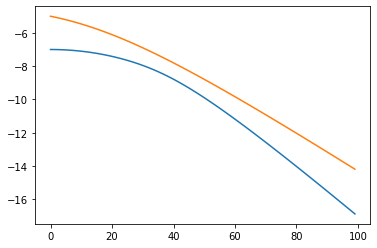

In [6]:
for en in range(np.shape(energies)[1]):
    plt.plot(energies[:,en])

In [7]:
idxs = [0,1]

In [8]:
E_states = []
    
for h in Hs.mat_Hs:
    eigvals, eigvecs = jnp.linalg.eigh(h)
    eigvals = np.sort(eigvals)

    E_state = []
    for k in range(1+1):
        E_state.append(eigvals[idxs[k]])

    E_states.append(E_state)

In [9]:
E_states = np.array(E_states)

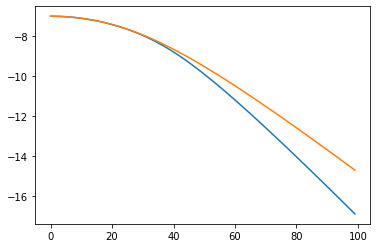

In [10]:
for en in range(np.shape(E_states)[1]):
    plt.plot(E_states[:,en])

In [11]:
import sys, os
sys.path.insert(0, '../../')
import PhaseEstimation.circuits as circuits
import PhaseEstimation.losses as losses

##############

def circuit_ising(N, params):
    """
    Full VQE circuit

    Parameters
    ----------
    N : int
        Number of qubits
    params: np.ndarray
        Array of parameters/rotation for the circuit

    Returns
    -------
    int
        Total number of parameters needed to build this circuit
    """
    # No wire will be measured until the end, the array of active
    # wire will correspont to np.arange(N) throughout the whole circuit
    active_wires = np.arange(N)
    index = 0
    qml.Barrier()
    for _ in range(6):
        index = circuits.circuit_ID9(active_wires, params, index)
        qml.Barrier()
        
    index = circuits.wall_gate(active_wires, qml.RX, params, index)
    
    return index

class vqe:
    def __init__(self, Hs, circuit):
        """
        Class for the VQE algorithm

        Parameters
        ----------
        Hs : class
            Custom Hamiltonian class
        circuit : function
            Function of the VQE circuit
        """
        self.N = Hs.N
        self.Hs = Hs
        self.n_states = Hs.n_states
        self.circuit = lambda p: circuit(self.N, p)
        self.n_params = self.circuit([0] * 10000)
        self.vqe_params = jnp.array( np.random.uniform(-np.pi, np.pi, size=(self.n_states,self.n_params)) ) 
        self.device = qml.device("default.qubit.jax", wires=self.N, shots=None)
        self.MSE = []
        self.vqe_e = []
        self.recycle = False
        self.states_dist = []

        self.circuit_fun = circuit
        
        @qml.qnode(self.device, interface="jax")
        def vqe_state(self):
            self.circuit(np.arange(self.n_params))

            return qml.state()

        self.drawer = qml.draw(vqe_state)(self)

    def train(self, lr, n_epochs, reg=0, circuit=False, recycle=True, save_trajectories = False, epochs_batch_size = 500, excited = False, beta = 0):
        """
        Training function for the VQE.

        Parameters
        ----------
        lr : float
            Learning rate to be multiplied in the circuit-gradient output
        n_epochs : int
            Total number of epochs for each learning
        reg : float
            Regularizer of the training function. It ensures the subsequent states are not
            too much different
        circuit : bool
            if True -> Prints the circuit
            if False -> It does not display the circuit
        plots : bool
            if True -> Display plots
            if False -> It does not display plots
        recycle : bool
            if True -> Each state (depending on the intensity of the magnetic field) is computed independently and in parallel.
            if False -> Each state is trained after the previous one, in which the initial parameters are the final learnt parameters of the previous state
        """
        # IDEA: Making the Jax version of a VQE eigensolver is a bit less intuitive that in the QCNN learning function,
        #       since here we have l_steps different circuits since each output of the circuit is <psi|H|psi> where H,
        #       changes for each datapoint.
        #       Here the output of each circuit is |psi>, while the Hs is moved to the loss function
        #       <PSI|Hs|PSI> is computed through two jax.einsum

        if circuit:
            # Display the circuit
            print("+--- CIRCUIT ---+")
            print(self.drawer)

        ### JAX FUNCTIONS ###
        # Circuit that returns the state |psi>
        @qml.qnode(self.device, interface="jax")
        def vqe_state(vqe_params):
            self.circuit(vqe_params)

            return qml.state()
        
        def compute_true_state(H):
            # Compute eigenvalues and eigenvectors
            eigval, eigvec = jnp.linalg.eigh(H)
            # Get the eigenstate to the lowest eigenvalue
            gstate = eigvec[:,jnp.argmin(eigval)]

            return gstate
        
        if excited:
            def psi_outer(psi):
                return jnp.outer(jnp.conj(psi), psi)

            outers = jax.vmap(psi_outer)(self.states)
            try:
                params = copy.copy(self.vqe_params1)
            except:
                params = jnp.array( np.random.uniform(-np.pi, np.pi, size=(self.n_states,self.n_params)) ) 
            operators = self.Hs.mat_Hs + beta * outers
        else:
            params = copy.copy(self.vqe_params)
            operators = self.Hs.mat_Hs
                
        jv_compute_true_state = jax.jit(jax.vmap(compute_true_state))
        self.true_states = jv_compute_true_state(self.Hs.mat_Hs)

        # vmap of the circuit
        v_vqe_state = jax.vmap(lambda v: vqe_state(v), in_axes=(0))

        # jitted vmap of the circuit
        jv_vqe_state = jax.jit(v_vqe_state)

        # jitted circuit
        j_vqe_state = jax.jit(lambda p: vqe_state(p))

        # computes <psi|H|psi>
        def compute_E(state, Hmat):
            return jnp.conj(state) @ Hmat @ state

        # vmapped function for <psi|H|psi>
        v_compute_E = jax.vmap(compute_E, in_axes=(0, 0))
        # jitted function for <psi|H|psi>
        j_compute_E = jax.jit(compute_E)

        # Same function as above but returns the energies not MSE
        def compute_vqe_E(param, Hmat):
            pred_states = j_vqe_state(param)
            vqe_e = j_compute_E(pred_states, Hmat)

            return jnp.real(vqe_e)

        j_compute_vqe_E = jax.jit(compute_vqe_E)
        v_compute_vqe_E = jax.vmap(compute_vqe_E, in_axes=(0, 0))

        # Same function as above but returns the energies not MSE
        def v_compute_vqe_E(params):
            pred_states = v_vqe_state(params)
            vqe_e = v_compute_E(pred_states, operators)

            return jnp.real(vqe_e)
            
        j_v_compute_vqe_E = jax.jit(v_compute_vqe_E)

        if not recycle:
            self.recycle = False
            oom = False
            jv_fidelties = jax.jit(lambda true, pars: losses.vqe_fidelties(true, pars, vqe_state) )
            
            def compute_diff_states(states):
                return jnp.mean(jnp.square(jnp.diff(jnp.real(states), axis=1)))
            
            def loss(params):
                pred_states = v_vqe_state(params)
                vqe_e = v_compute_E(pred_states, operators)

                if reg != 0:
                    return jnp.mean(jnp.real(vqe_e)) + reg * compute_diff_states(pred_states)
                else:
                    return jnp.mean(jnp.real(vqe_e))

            # Grad function of the MSE, used in updating the parameters
            jd_loss = jax.jit(jax.grad(loss))
            
            def update(params, opt_state):
                grads = jd_loss(params)
                opt_state = opt_update(0, grads, opt_state)
                
                return get_params(opt_state), opt_state 

            progress = tqdm.tqdm(range(n_epochs), position=0, leave=True)

            MSE = []
            self.trajectory = []
            
            # Defining an optimizer in Jax
            opt_init, opt_update, get_params = optimizers.adam(lr)
            opt_state = opt_init(params)
            
            for it in progress:
                params, opt_state = update(params, opt_state)
                
                # I want to skip when it == 0
                if (it + 1) % epochs_batch_size == 0:
                    if not oom:
                        try:
                            MSE.append(
                                jnp.mean(jnp.square(j_v_compute_vqe_E(params) - self.Hs.true_e))
                            )
                        except RuntimeError:
                            oom = True
                            MSE.append(
                                jnp.mean(jnp.square(v_compute_vqe_E(params) - self.Hs.true_e))
                            )
                    else:
                        MSE.append(
                                jnp.mean(jnp.square(v_compute_vqe_E(params) - self.Hs.true_e))
                            )

                    # Update progress bar
                    progress.set_description("Cost: {0:.4f} | Mean F.: {1:.4f}".format(MSE[-1], jv_fidelties(self.true_states, jnp.array(params)) ) )
                
                if it % 10 == 0:
                    if save_trajectories:
                        self.trajectory.append(params)
        else:
            self.recycle = True
            oom = False
            
            # Computes MSE of the true energies - vqe energies: function to minimize
            def loss_reg(param, Hmat, reg, previous_state):
                pred_state = j_vqe_state(param)
                vqe_e = j_compute_E(pred_state, Hmat)
                
                return jnp.real(vqe_e) + reg * jnp.square(jnp.abs(jnp.conj(pred_state) @  previous_state))
            
            def loss(param, Hmat):
                pred_state = j_vqe_state(param)
                vqe_e = j_compute_E(pred_state, Hmat)
                
                return jnp.real(vqe_e)
    
            # Grad function of the MSE, used in updating the parameters
            jd_loss_reg = jax.jit(jax.grad(loss_reg))
            jd_loss = jax.jit(jax.grad(loss))
            
            def update(param, opt_state, Hmat):
                grads = jd_loss(param, Hmat)
                opt_state = opt_update(0, grads, opt_state)
                
                return get_params(opt_state), opt_state 
            
            def update_reg(param, opt_state, Hmat, reg, previous_state):
                grads = jd_loss_reg(param, Hmat, reg, previous_state)
                opt_state = opt_update(0, grads, opt_state)
                
                return get_params(opt_state), opt_state 

            progress = tqdm.tqdm(self.Hs.recycle_rule[1:], position=0, leave=True)
            params = [[0]*self.n_params]*self.n_states
            param = jnp.array(np.random.rand(self.n_params))
            
            MSE = []
            previous_pred_states = []
            
            idx = 0
            
            # Defining an optimizer in Jax
            opt_init, opt_update, get_params = optimizers.adam(lr)
            opt_state = opt_init(param)
            
            if excited:
                operators = self.Hs.mat_Hs + outers
            for it in range(10*n_epochs):
                param, opt_state = update(param, opt_state, self.Hs.mat_Hs[idx])
                
            previous_state = j_vqe_state(param)
            params[idx] = copy.copy(param)
            progress.set_description("{0}/{1}".format(idx + 1, self.n_states))
            
            for idx in (progress):
                opt_init, opt_update, get_params = optimizers.adam(lr)
                opt_state = opt_init(param)
                
                for it in range(n_epochs):
                    param, opt_state = update_reg(param, opt_state, operators[idx], reg, previous_state)
                        
                params[idx] = copy.copy(param)
                progress.set_description("{0}/{1}".format(idx + 1, self.n_states))
                previous_state = j_vqe_state(param)
            params = jnp.array(params)

        
        if not excited: 
            self.MSE = MSE
            self.vqe_params = params
            if not oom:
                self.vqe_e = j_v_compute_vqe_E(params)
                self.states = jv_vqe_state(params)
            else:
                self.vqe_e = v_compute_vqe_E(params)
                self.states = v_vqe_state(params)
        else:
            self.MSE1 = MSE
            self.vqe_params1 = params
            if not oom:
                self.vqe_e1 = j_v_compute_vqe_E(params)
                self.states1 = jv_vqe_state(params)
            else:
                self.vqe_e1 = v_compute_vqe_E(params)
                self.states1 = v_vqe_state(params)        
        

In [12]:
Hs = hamiltonians.hamiltonian(ising_chain.build_Hs, N = N, n_states = 100, J = 1)

In [13]:
myvqe = vqe(Hs, circuit_ising)

In [14]:
myvqe.train(.5, 50, circuit = False, recycle = True, reg = 0)
myvqe.train(.3, 10000, circuit = False, recycle = False, reg = 50)

100/100: 100%|██████████████████████████████████| 99/99 [00:38<00:00,  2.60it/s]
Cost: 0.0007 | Mean F.: 0.8310: 100%|████| 10000/10000 [00:57<00:00, 172.47it/s]


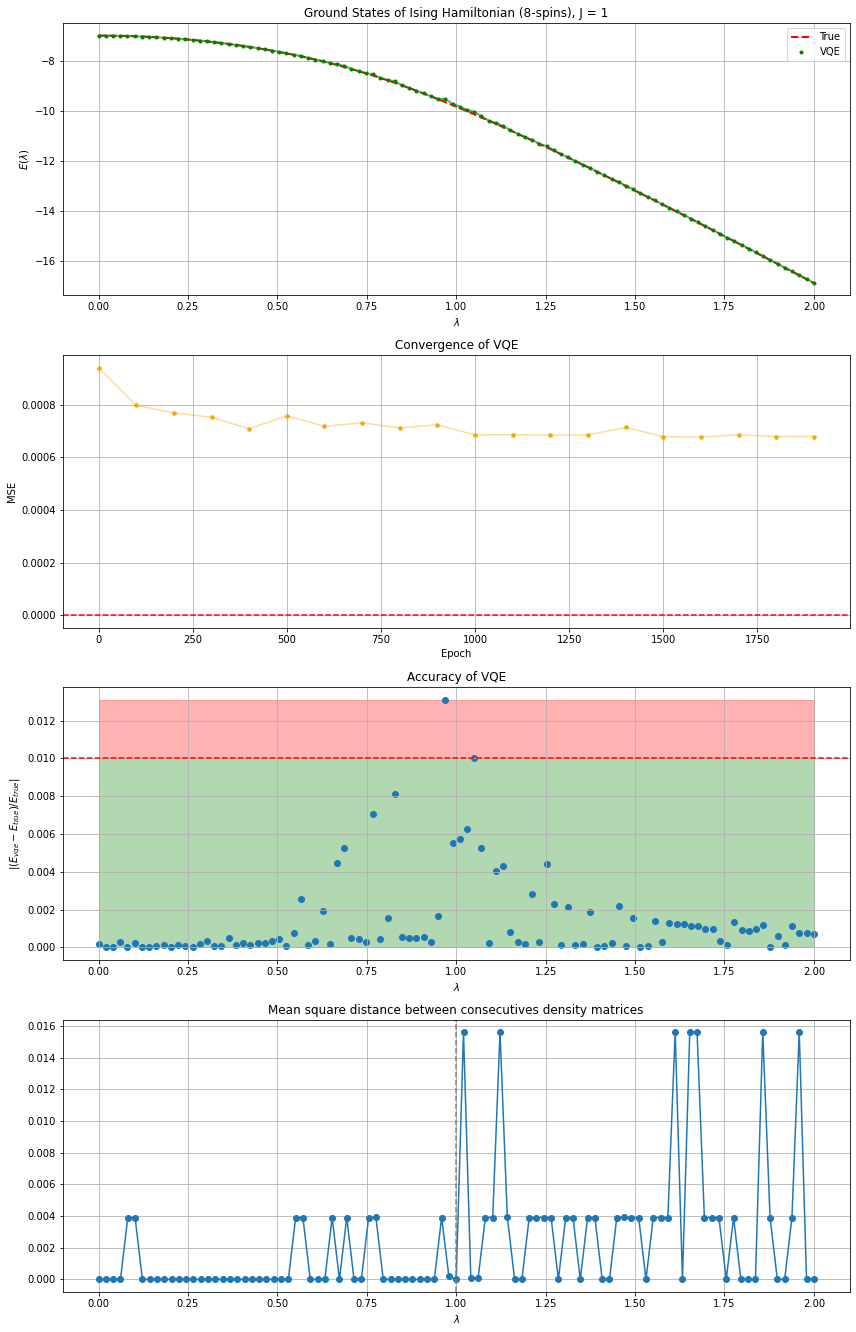

In [15]:
qplt.show_VQE_isingchain(myvqe)

In [42]:
myvqe.train(.5, 100, circuit = False, recycle = True, reg = 0, excited = True, beta = 5)
myvqe.train(.3, 20000, circuit = False, recycle = False, reg = 0, excited = True, beta = 10)

100/100: 100%|██████████████████████████████████| 99/99 [00:55<00:00,  1.77it/s]
Cost: 1.0354 | Mean F.: 0.1671: 100%|████| 20000/20000 [01:39<00:00, 201.69it/s]


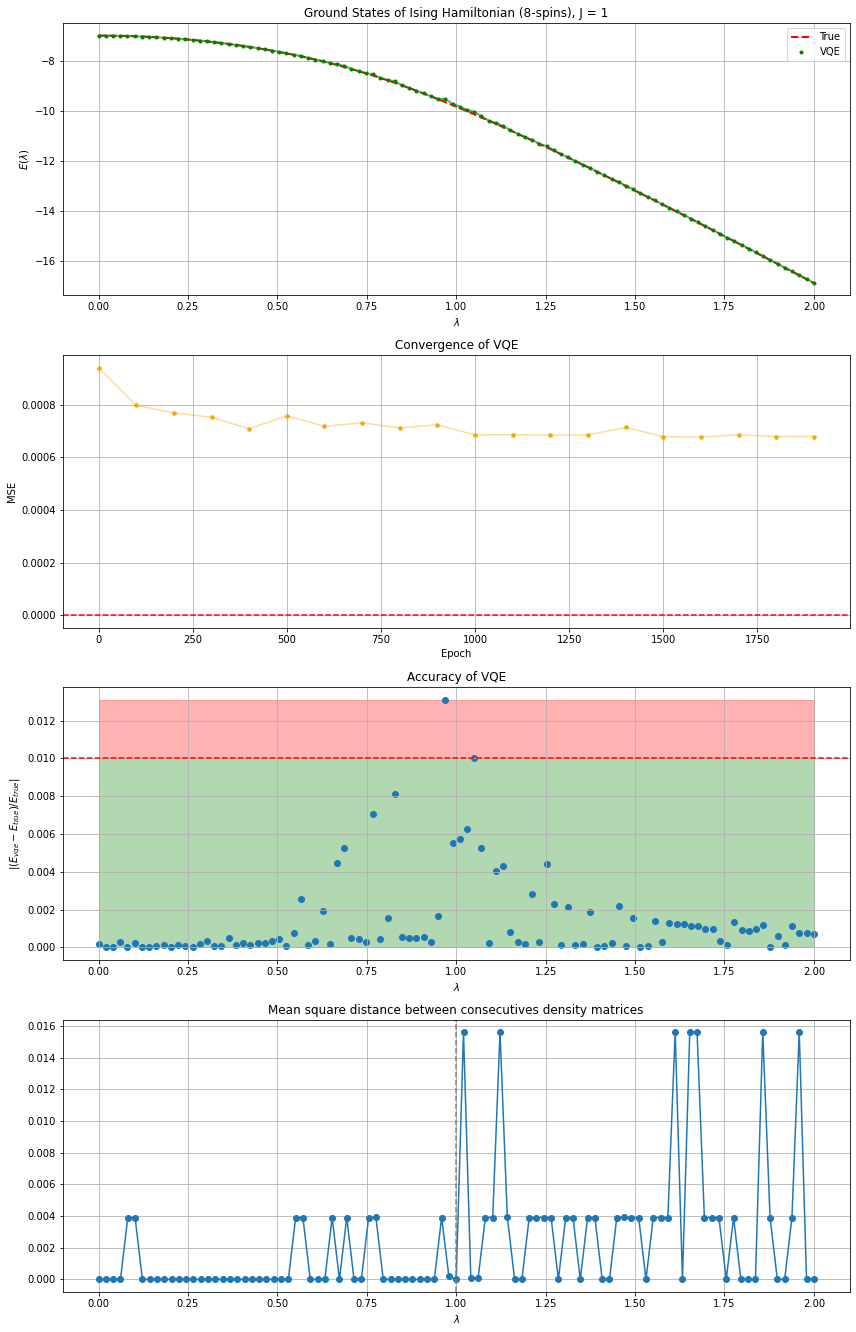

In [17]:
qplt.show_VQE_isingchain(myvqe)

In [43]:
vqe_e = myvqe.vqe_e1

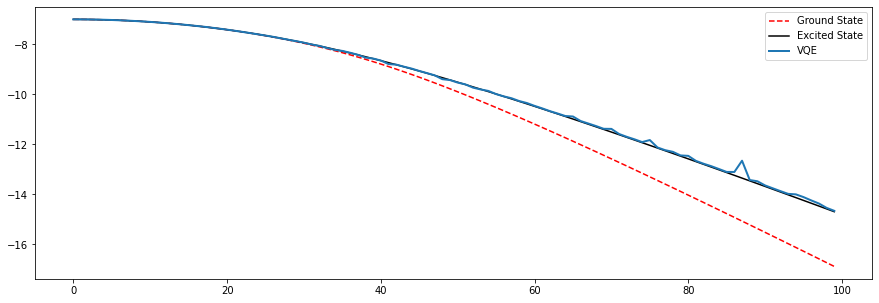

In [44]:
plt.figure(figsize=(15,5))
labels = ['Ground State', 'Excited State']
k = 0
plt.plot(E_states[:,0], '--', color = 'red', label = labels[0])
plt.plot(E_states[:,1], color = 'black', label = labels[1])
plt.plot(vqe_e, lw = 2, label= 'VQE')
plt.legend()